# Gait Classification

The goal of this exercise is to classify three types of gaits from windows of stride intervals. The stride intervals we will use are extracted from the Gait in Aging and Disease Database (https://physionet.org/content/gaitdb/1.0.0/).

This database includes stride intervals collected from 15 subjects: 5 healthy young adults, 5 healthy old adults, and 5 older adults with Parkinson's disease. Windows of 32 stride intervals (with 50% overlap) are already extracted from the raw data.

First, we import all required packages, define global constants, and seed the random number generators to obtain reproducible results.

In [1]:
%matplotlib widget


import itertools
import logging
import operator
import pathlib
import warnings

import IPython.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import seaborn as sns
import sklearn.metrics
import sklearn.model_selection
import sklearn.preprocessing
import torch


DATA_FILE = pathlib.Path('../data/gaitdb_intervals.npz')
LOG_DIRECTORY = pathlib.Path('../logs/gait_classification')


# Disable logging for PyTorch Lightning to avoid too long outputs.
logging.getLogger('pytorch_lightning').setLevel(logging.ERROR)

# Seed random number generators for reproducible results.
pl.seed_everything(42)

Seed set to 42


42

Then, we load the windows of stride intervals and the corresponding labels.

In [2]:
def load_data():
    with np.load(DATA_FILE) as data:
        intervals = data['intervals']
        labels = data['labels']
        subjects = data['subjects']
    return intervals, labels, subjects


intervals, labels, subjects = load_data()

print(f'Number of windows : {intervals.shape[0]}')
print(f'Window size       : {intervals.shape[1]}')
print(f'Classes           : {np.unique(labels)}')
print(f'Subjects          : {np.unique(subjects)}')

Number of windows : 550
Window size       : 32
Classes           : ['old' 'parkinson' 'young']
Subjects          : ['o1' 'o2' 'o3' 'o4' 'o5' 'pd1' 'pd2' 'pd3' 'pd4' 'pd5' 'y1' 'y2' 'y3'
 'y4' 'y5']


We plot a few examples of stride interval windows for the different classes.

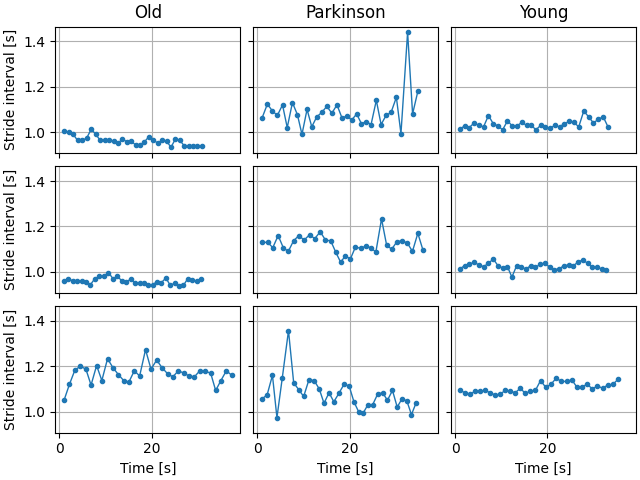

In [3]:
def plot_stride_examples(intervals, labels, n=3):
    classes = np.unique(labels)
    fig, axes = plt.subplots(n, len(classes), squeeze=False, 
                             sharex='all', sharey='all', constrained_layout=True)
            
    
    def plot_intervals(ax, x):
        t = np.cumsum(x)
        ax.plot(t, x, '.-', linewidth=1)
        ax.grid(True)
        
    for i, cls in enumerate(classes):
        indices = np.flatnonzero(labels == cls)
        indices = np.random.choice(indices, size=n)
        for j in range(n):
            if j == 0:
                axes[j, i].set_title(cls.capitalize())
            plot_intervals(axes[j, i], intervals[indices[j]])
    
    plt.setp(axes[:, 0], ylabel='Stride interval [s]')
    plt.setp(axes[-1, :], xlabel='Time [s]')
    
    
plot_stride_examples(intervals, labels)

**Question 1**

Are there any visible differences between the three classes in these examples?

**Answer:**

bof

Then, we split data into subsets for training (60%), validation (20%), and testing (20%) stratified by labels.

In [4]:
def split_data(labels):
    n = labels.size
    splitter = sklearn.model_selection.StratifiedKFold(n_splits=5, shuffle=True)
    indices = list(map(operator.itemgetter(1), splitter.split(np.zeros((n, 1)), labels)))
    i_train = np.hstack(indices[:-2])
    i_val = indices[-2]
    i_test = indices[-1]
    
    assert np.intersect1d(i_train, i_val).size == 0
    assert np.intersect1d(i_train, i_test).size == 0
    assert np.intersect1d(i_val, i_test).size == 0
    assert np.all(np.sort(np.hstack((i_train, i_val, i_test))) == np.arange(n))
    
    return i_train, i_val, i_test


i_train, i_val, i_test = split_data(labels)


def build_summary(labels, indices):
    classes = np.unique(labels)
    data = []
    for subset, i in indices:
        y = labels[i]
        data.append({'subset': subset, 'total_count': y.size})
        for cls in classes:
            data[-1][f'{cls}_count'] = np.sum(y == cls)
    return pd.DataFrame(data)
    

IPython.display.display(build_summary(labels, (('train', i_train), ('val', i_val), ('test', i_test))))
print(f'Subjects in training set   : {np.unique(subjects[i_train])}')
print(f'Subjects in validation set : {np.unique(subjects[i_val])}')
print(f'Subjects in test set       : {np.unique(subjects[i_test])}')

,subset,total_count,old_count,parkinson_count,young_count
0,train,330,150,42,138
1,val,110,50,13,47
2,test,110,49,14,47


Subjects in training set   : ['o1' 'o2' 'o3' 'o4' 'o5' 'pd1' 'pd2' 'pd3' 'pd4' 'pd5' 'y1' 'y2' 'y3'
 'y4' 'y5']
Subjects in validation set : ['o1' 'o2' 'o3' 'o4' 'o5' 'pd1' 'pd2' 'pd3' 'pd4' 'pd5' 'y1' 'y2' 'y3'
 'y4' 'y5']
Subjects in test set       : ['o1' 'o2' 'o3' 'o4' 'o5' 'pd1' 'pd2' 'pd3' 'pd4' 'pd5' 'y1' 'y2' 'y3'
 'y4' 'y5']


**Question 2**

Comment on the method used to split data into training, validation, and test sets. Is is appropriate? What would be another approach?

This method preserves the class distribution of the sample set. If this distribution is not uniform, then the classifier will be biased towards the most probable class. To avoid this, one could resample the dataset to obtain training, validation and test sets with uniform class distributions.

To better understand the data, we visualize the mean and standard deviation of each window of stride intervals in the training set.

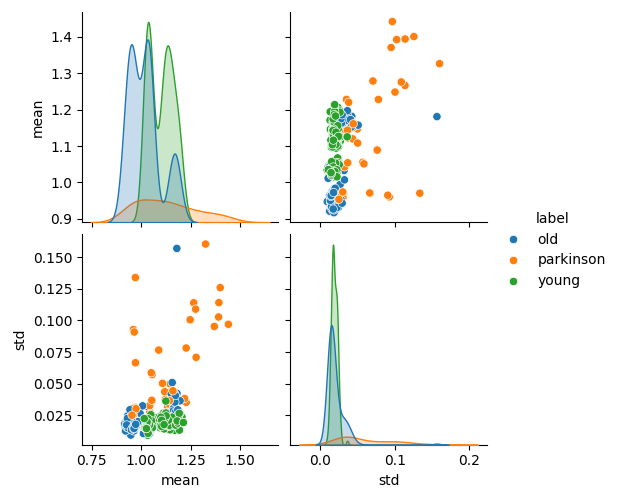

In [5]:
def plot_stats(intervals, labels):
    data = pd.DataFrame({
        'label': labels,
        'mean': np.mean(intervals, axis=1),
        'std': np.std(intervals, axis=1),
    })
    sns.pairplot(data, hue='label')
    
    
plot_stats(intervals[i_train], labels[i_train])

To ensure the training procedure is stable, we center and scale the windows of stride intervals such that they have approximately zero mean and unit variance.

In [6]:
def scale_intervals(intervals, i_train):
    intervals = intervals - np.mean(intervals[i_train])
    intervals = intervals / np.std(intervals[i_train])
    return intervals


def print_stats(intervals, i_train, i_val, i_test):
    subsets = (
        ('Training set', i_train),
        ('Validation set', i_val), 
        ('Test set', i_test),
    )
    for name, i in subsets:
        mu = np.mean(intervals[i])
        sigma = np.std(intervals[i])
        print(f'{name:14} : {mu:+.3f} ± {sigma:.3f}')

        
print('Before scaling')
print_stats(intervals, i_train, i_val, i_test)

scaled_intervals = scale_intervals(intervals, i_train)

print('\nAfter scaling')
print_stats(scaled_intervals, i_train, i_val, i_test)

Before scaling
Training set   : +1.067 ± 0.100
Validation set : +1.071 ± 0.100
Test set       : +1.074 ± 0.100

After scaling
Training set   : +0.000 ± 1.000
Validation set : +0.042 ± 0.991
Test set       : +0.074 ± 0.996


We also encode the labels with one-hot encoding.

In [7]:
def encode_labels(labels):
    categories = [np.unique(labels)]
    encoder = sklearn.preprocessing.OneHotEncoder(categories=categories, sparse_output=False)
    return encoder.fit_transform(labels[:, None])


encoded_labels = encode_labels(labels)


def print_encoded_labels(labels, encoded_labels, n=10):
    df = pd.DataFrame(encoded_labels, columns=np.unique(labels))
    df.insert(0, 'class', labels)
    df = df.iloc[np.random.permutation(len(df)), :]
    IPython.display.display(df.head(n))
    
    
print_encoded_labels(labels, encoded_labels)

,class,old,parkinson,young
423,young,0.0,0.0,1.0
548,young,0.0,0.0,1.0
437,young,0.0,0.0,1.0
324,young,0.0,0.0,1.0
122,old,1.0,0.0,0.0
446,young,0.0,0.0,1.0
128,old,1.0,0.0,0.0
520,young,0.0,0.0,1.0
15,old,1.0,0.0,0.0
170,old,1.0,0.0,0.0


We implement two models to classify the stride intervals: a multi-layer perceptron (MLP) and a convolutional neural network (CNN).

In [8]:
class MlpModel(torch.nn.Module):
    
    def __init__(self, 
                 input_size, 
                 output_size, 
                 n_hidden_layers=1, 
                 n_units=128, 
                 dropout=0.0):
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.n_hidden_layers = n_hidden_layers
        self.n_units = n_units
        self.dropout = dropout
        self.layers = self._build_layers()
    
    def _build_layers(self):
        sizes = [self.input_size]
        sizes.extend(itertools.repeat(self.n_units, self.n_hidden_layers))
        layers = []
        for i in range(self.n_hidden_layers):
            layers.append(torch.nn.Linear(sizes[i], sizes[i + 1]))
            layers.append(torch.nn.ReLU())
            if 0.0 < self.dropout < 1.0:
                layers.append(torch.nn.Dropout(self.dropout))
        layers.append(torch.nn.Linear(sizes[-1], self.output_size))
        return torch.nn.Sequential(*layers)
    
    def forward(self, x):
        return self.layers(x)
    

class CnnModel(torch.nn.Module):
    
    def __init__(self, 
                 input_size,
                 output_size,
                 n_layers=3,
                 n_initial_channels=8,
                 kernel_size=3):
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.n_initial_channels = n_initial_channels
        self.kernel_size = kernel_size
        self.layers = self._build_layers()
        
    def _build_layers(self):
        layers = []
        
        n_output_channels = 1
        for i in range(self.n_layers):
            n_input_channels = n_output_channels
            n_output_channels = self.n_initial_channels * 2 ** i
            layers.append(torch.nn.Conv1d(
                in_channels=n_input_channels,
                out_channels=n_output_channels,
                kernel_size=self.kernel_size,
                padding='same',
            ))
            layers.append(torch.nn.ReLU())
            if i < self.n_layers - 1:
                layers.append(torch.nn.MaxPool1d(kernel_size=2))
            else:
                layers.append(torch.nn.AdaptiveAvgPool1d(1))
        layers.append(torch.nn.Flatten())
        
        layers.append(torch.nn.Linear(
            in_features=self.n_initial_channels * 2 ** (self.n_layers - 1),
            out_features=self.output_size,
        ))
        
        return torch.nn.Sequential(*layers)
    
    def forward(self, x):
        x = x.view(x.shape[0], 1, x.shape[1])
        return self.layers(x)

We also define a classifier class and utility functions to make it easier to train and evaluate models.

In [9]:
class Classifier(pl.LightningModule):
    
    def __init__(self, config):
        super().__init__()
        self.save_hyperparameters()
        self.config = config
        self.model = self._build_model()
        self.example_input_array = torch.zeros((1, self.model.input_size))
    
    def _build_model(self):
        name = self.config['model']['name']
        config = self.config['model'].get('config', {})
        if name == 'mlp':
            return MlpModel(**config)
        elif name == 'cnn':
            return CnnModel(**config)
        else:
            raise ValueError(f'unknown model: {name!r}')
            
    def configure_optimizers(self):
        name = self.config['optimizer']['name']
        config = self.config['optimizer'].get('config', {})
        if name == 'sgd':
            return torch.optim.SGD(self.parameters(), **config)
        elif name == 'adam':
            return torch.optim.Adam(self.parameters(), **config)
        else:
            raise ValueError(f'unknown optimizer: {name!r}')
            
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        return self._run_step(batch, 'train')
    
    def validation_step(self, batch, batch_idx):
        self._run_step(batch, 'val')
        
    def test_step(self, batch, batch_idx):
        self._run_step(batch, 'test')
        
    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        x, y = batch
        return self.model(x)
    
    def _run_step(self, batch, subset):
        x, y = batch
        logits = self.model(x)
        loss = torch.nn.functional.cross_entropy(logits, y)
        acc = (torch.argmax(y, 1) == torch.argmax(logits, 1)).float().mean()
        self.log_dict({
            f'{subset}_loss': loss,
            f'{subset}_acc': acc,
        }, on_step=False, on_epoch=True, prog_bar=True)
        return loss


def build_loader(*tensors, batch_size=50, shuffle=False, n_workers=0):
    dataset = torch.utils.data.TensorDataset(*map(torch.Tensor, tensors))
    return torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=n_workers,
    )


def train_model(name, config, x, y, i_train, i_val, batch_size=50, n_epochs=10):
    train_loader = build_loader(x[i_train], y[i_train], batch_size=batch_size, shuffle=True)
    val_loader = build_loader(x[i_val], y[i_val], batch_size=batch_size)
    classifier = Classifier(config)
    print(pl.utilities.model_summary.ModelSummary(classifier, max_depth=-1))
    
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        trainer = pl.Trainer(
            default_root_dir=LOG_DIRECTORY,
            logger=pl.loggers.TensorBoardLogger(LOG_DIRECTORY, name),
            enable_model_summary=False,
            max_epochs=n_epochs,
        )
        trainer.fit(classifier, train_loader, val_loader)

    return classifier


def evaluate_model(model, x, y, i_train, i_val, i_test, batch_size=50):
    loader = build_loader(x, y, batch_size=batch_size)
    
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')
        trainer = pl.Trainer(
            default_root_dir=LOG_DIRECTORY,
            logger=False,
            enable_progress_bar=False,
            enable_model_summary=False,
        )
        z = trainer.predict(model, loader)
    z = np.vstack([u.numpy() for u in z])
    
    references = np.argmax(y, axis=1)
    predictions = np.argmax(z, axis=1)
    matrices = {}
    for subset, indices in (('train', i_train), ('val', i_val), ('test', i_test)):
        matrices[subset] = sklearn.metrics.confusion_matrix(
            references[indices],
            predictions[indices],
        )
        
    return matrices

Finally, we define functions to plot confusion matrices.

In [10]:
def plot_confusion_matrix(c, labels=None, title=None):
    c = np.asarray(c)

    fig = plt.figure(figsize=(5, 4), constrained_layout=True)
    image = plt.imshow(c, cmap='Blues', interpolation='nearest')

    threshold = (c.min() + c.max()) / 2
    for i, j in itertools.product(range(c.shape[0]), repeat=2):
        if c[i, j] < threshold:
            color = image.cmap(image.cmap.N)
        else:
            color = image.cmap(0)
        text = format(c[i, j], '.2g')
        if c.dtype.kind != 'f':
            integer_text = format(c[i, j], 'd')
            if len(integer_text) < len(text):
                text = integer_text
        plt.text(j, i, text, color=color, ha='center', va='center')

    if labels is not None:
        plt.xticks(np.arange(c.shape[-1]), labels, rotation=45, ha='right')
        plt.yticks(np.arange(c.shape[-1]), labels)
    plt.xlabel('Predictions')
    plt.ylabel('References')
    if title is not None:
        plt.title(title)



def plot_confusion_matrices(matrices, labels):
    for subset in ('train', 'val', 'test'):
        c = matrices[subset]
        accuracy = np.trace(c) / c.sum()
        c = c / np.sum(c, axis=1, keepdims=True)
        title = f'{subset.capitalize()} set (accuracy = {accuracy:.3f})'
        plot_confusion_matrix(c, labels=labels, title=title)

We use TensorBoard to visualize performance metrics during training.

If you prefer to view TensorBoard in a separate window, you can open http://localhost:6006/ in your web browser.

In [11]:
%reload_ext tensorboard
%tensorboard --logdir ../logs/gait_classification --port 6006

We define a configuration for an MLP model with the following layers:

* Dense layer (output size = 128)
* ReLU activation
* Dense layer (output size = 128)
* ReLU activation
* Dense layer (output size = 3)

We then train the MLP model with stochastic gradient descent (SGD) and evaluate it.

  | Name           | Type       | Params | Mode  | In sizes | Out sizes
-----------------------------------------------------------------------------
0 | model          | MlpModel   | 21.1 K | train | [1, 32]  | [1, 3]   
1 | model.layers   | Sequential | 21.1 K | train | [1, 32]  | [1, 3]   
2 | model.layers.0 | Linear     | 4.2 K  | train | [1, 32]  | [1, 128] 
3 | model.layers.1 | ReLU       | 0      | train | [1, 128] | [1, 128] 
4 | model.layers.2 | Linear     | 16.5 K | train | [1, 128] | [1, 128] 
5 | model.layers.3 | ReLU       | 0      | train | [1, 128] | [1, 128] 
6 | model.layers.4 | Linear     | 387    | train | [1, 128] | [1, 3]   
-----------------------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainable params
21.1 K    Total params
0.084     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

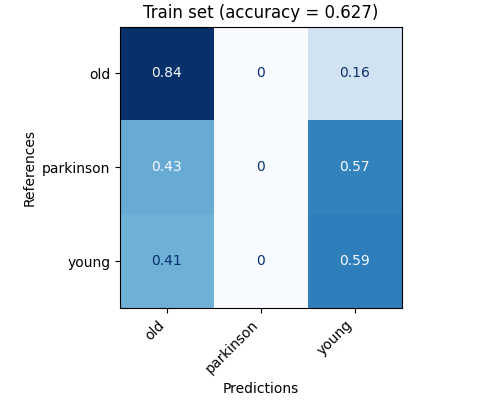

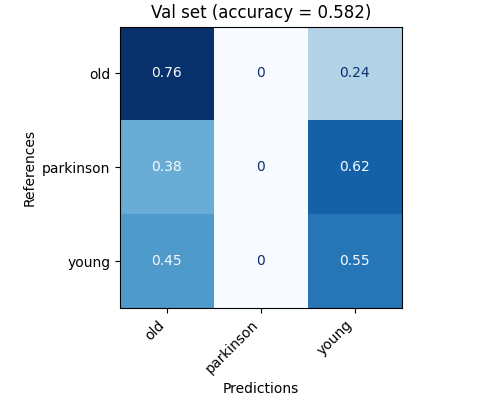

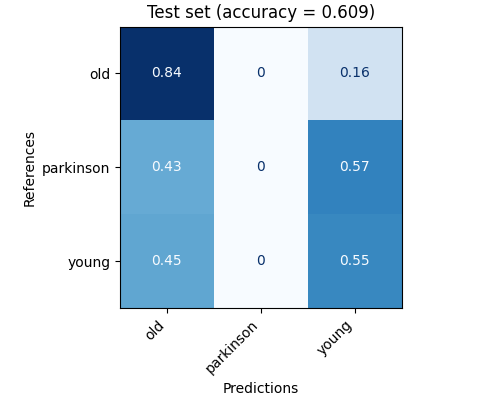

In [12]:
batch_size = 10
n_epochs = 200

mlp_config = {
    'model': {
        'name': 'mlp',
        'config': {
            'input_size': scaled_intervals.shape[1],
            'output_size': encoded_labels.shape[1],
            'n_hidden_layers': 2,
            'n_units': 128,
        },
    },
    'optimizer': {
        'name': 'sgd',
        'config': {
            'lr': 0.0001,
        },
    },
}

mlp_model = train_model(
    name='mlp', 
    config=mlp_config, 
    x=scaled_intervals, 
    y=encoded_labels, 
    i_train=i_train, 
    i_val=i_val,
    batch_size=batch_size,
    n_epochs=n_epochs,
)

mlp_matrices = evaluate_model(
    model=mlp_model, 
    x=scaled_intervals, 
    y=encoded_labels, 
    i_train=i_train, 
    i_val=i_val,
    i_test=i_test,
)

plot_confusion_matrices(mlp_matrices, np.unique(labels))

**Question 3**

Based on the metrics shown in TensorBoard, comment on the training procedure. Does the model overfit?

Based on the confusion matrices, what is the main issue of the model? What is a probable explanation for these results?

**Answer:**

The model seems to get stuck in a local minimum, as the training accuracy stops increasing past a number of epochs. A overfitting model would see its training accuracy increase while its validation accuracy stays constant.

Most importantly, the model never classifies any sample as `parkinson`. This could be due to the lower proportion of parkinson subjects in the dataset.

Next, we train and evaluate the same MLP model architecture except that this time we use SGD with momentum for optimizing the parameters.

  | Name           | Type       | Params | Mode  | In sizes | Out sizes
-----------------------------------------------------------------------------
0 | model          | MlpModel   | 21.1 K | train | [1, 32]  | [1, 3]   
1 | model.layers   | Sequential | 21.1 K | train | [1, 32]  | [1, 3]   
2 | model.layers.0 | Linear     | 4.2 K  | train | [1, 32]  | [1, 128] 
3 | model.layers.1 | ReLU       | 0      | train | [1, 128] | [1, 128] 
4 | model.layers.2 | Linear     | 16.5 K | train | [1, 128] | [1, 128] 
5 | model.layers.3 | ReLU       | 0      | train | [1, 128] | [1, 128] 
6 | model.layers.4 | Linear     | 387    | train | [1, 128] | [1, 3]   
-----------------------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainable params
21.1 K    Total params
0.084     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

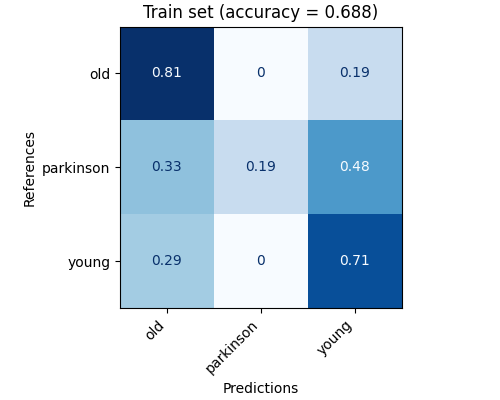

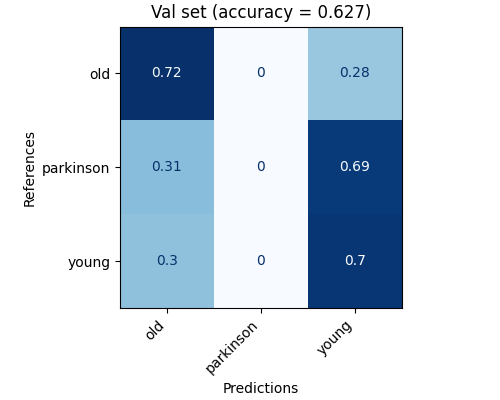

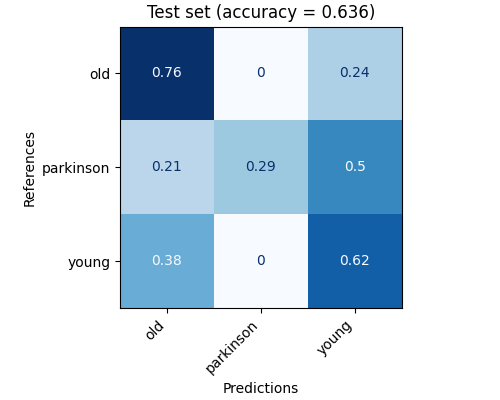

In [13]:
mlp_momentum_config = {
    'model': {
        'name': 'mlp',
        'config': {
            'input_size': scaled_intervals.shape[1],
            'output_size': encoded_labels.shape[1],
            'n_hidden_layers': 2,
            'n_units': 128,
        },
    },
    'optimizer': {
        'name': 'sgd',
        'config': {
            'lr': 0.0001,
            'momentum': 0.9,
        },
    },
}

mlp_momentum_model = train_model(
    name='mlp_momentum', 
    config=mlp_momentum_config, 
    x=scaled_intervals, 
    y=encoded_labels, 
    i_train=i_train, 
    i_val=i_val,
    batch_size=batch_size,
    n_epochs=n_epochs,
)

mlp_momentum_matrices = evaluate_model(
    model=mlp_momentum_model, 
    x=scaled_intervals, 
    y=encoded_labels, 
    i_train=i_train, 
    i_val=i_val,
    i_test=i_test,
)

plot_confusion_matrices(mlp_momentum_matrices, np.unique(labels))

**Question 4**

What is the main difference of using momentum for training? Does the model overfit? Does momentum help to significantly improve the model accuracy?

**Answer:**

The momentum allows escaping local minima of the loss optimization landscape. This helps the model to learn to recognize parkinson subjects, eventually increasing the end accuracy.

Now, we use the same MLP architecture again, but we use the [Adam optimizer](https://arxiv.org/abs/1412.6980) for training instead of SGD.

  | Name           | Type       | Params | Mode  | In sizes | Out sizes
-----------------------------------------------------------------------------
0 | model          | MlpModel   | 21.1 K | train | [1, 32]  | [1, 3]   
1 | model.layers   | Sequential | 21.1 K | train | [1, 32]  | [1, 3]   
2 | model.layers.0 | Linear     | 4.2 K  | train | [1, 32]  | [1, 128] 
3 | model.layers.1 | ReLU       | 0      | train | [1, 128] | [1, 128] 
4 | model.layers.2 | Linear     | 16.5 K | train | [1, 128] | [1, 128] 
5 | model.layers.3 | ReLU       | 0      | train | [1, 128] | [1, 128] 
6 | model.layers.4 | Linear     | 387    | train | [1, 128] | [1, 3]   
-----------------------------------------------------------------------------
21.1 K    Trainable params
0         Non-trainable params
21.1 K    Total params
0.084     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

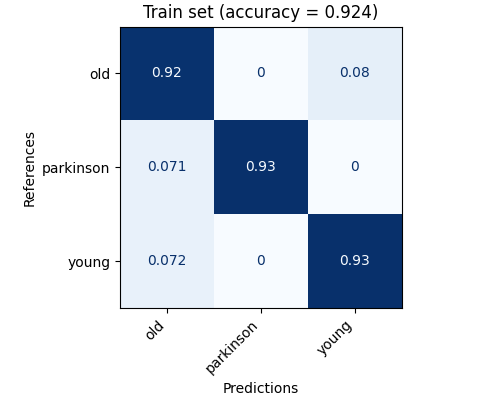

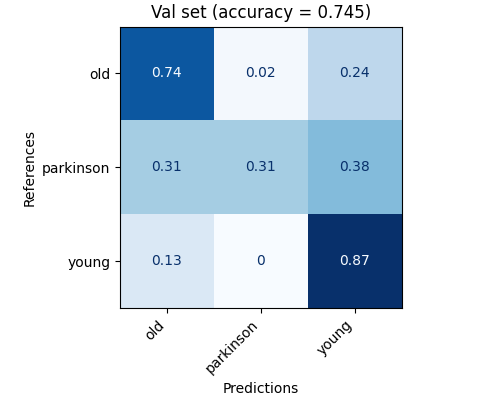

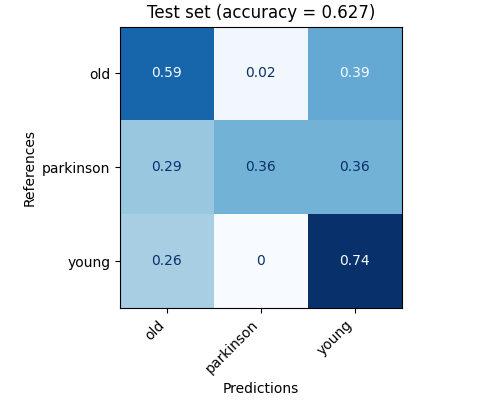

In [14]:
mlp_adam_config = {
    'model': {
        'name': 'mlp',
        'config': {
            'input_size': scaled_intervals.shape[1],
            'output_size': encoded_labels.shape[1],
            'n_hidden_layers': 2,
            'n_units': 128,
        },
    },
    'optimizer': {
        'name': 'adam',
        'config': {
            'lr': 0.0001,
        },
    },
}

mlp_adam_model = train_model(
    name='mlp_adam', 
    config=mlp_adam_config, 
    x=scaled_intervals, 
    y=encoded_labels, 
    i_train=i_train, 
    i_val=i_val,
    batch_size=batch_size,
    n_epochs=n_epochs,
)

mlp_adam_matrices = evaluate_model(
    model=mlp_adam_model, 
    x=scaled_intervals, 
    y=encoded_labels, 
    i_train=i_train, 
    i_val=i_val,
    i_test=i_test,
)

plot_confusion_matrices(mlp_adam_matrices, np.unique(labels))

**Question 5**

What are the main differences of the MLP model trained with the Adam optimized compared to the models trained with SGD (with and without momentum)? Does the model overfit? Does the Adam optimizer help to achieve better overall performance (as shown in the confusion matrices)?

**Answer:**

Finally, we train a CNN model with the Adam optimizer. This model includes the following layers:

* Convolutional layer (kernel size = 3, output size = 32, output channels = 8)
* ReLU activation
* Max pooling (output size = 16, output channels = 8)
* Convolutional layer (kernel size = 3, output size = 16, output channels = 16)
* ReLU activation
* Max pooling (output size = 8, output channels = 16)
* Convolutional layer (kernel size = 3, output size = 8, output channels = 32)
* ReLU activation
* Global average pooling (output size = 32)
* Dense layer (output size = 3)

   | Name            | Type              | Params | Mode  | In sizes    | Out sizes  
-------------------------------------------------------------------------------------------
0  | model           | CnnModel          | 2.1 K  | train | [1, 32]     | [1, 3]     
1  | model.layers    | Sequential        | 2.1 K  | train | [1, 1, 32]  | [1, 3]     
2  | model.layers.0  | Conv1d            | 32     | train | [1, 1, 32]  | [1, 8, 32] 
3  | model.layers.1  | ReLU              | 0      | train | [1, 8, 32]  | [1, 8, 32] 
4  | model.layers.2  | MaxPool1d         | 0      | train | [1, 8, 32]  | [1, 8, 16] 
5  | model.layers.3  | Conv1d            | 400    | train | [1, 8, 16]  | [1, 16, 16]
6  | model.layers.4  | ReLU              | 0      | train | [1, 16, 16] | [1, 16, 16]
7  | model.layers.5  | MaxPool1d         | 0      | train | [1, 16, 16] | [1, 16, 8] 
8  | model.layers.6  | Conv1d            | 1.6 K  | train | [1, 16, 8]  | [1, 32, 8] 
9  | model.layers.7  | ReLU              | 0    

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

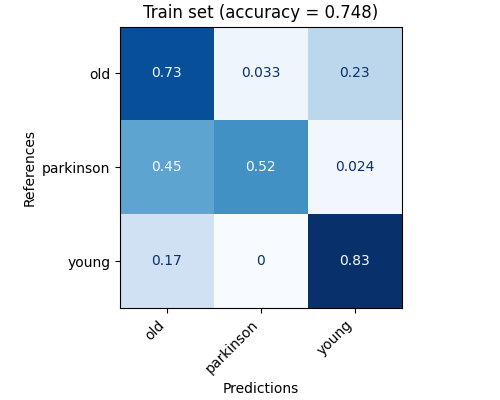

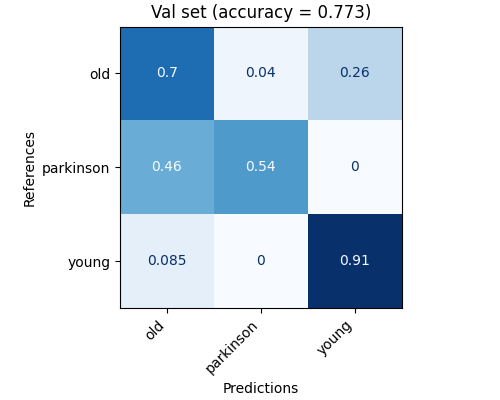

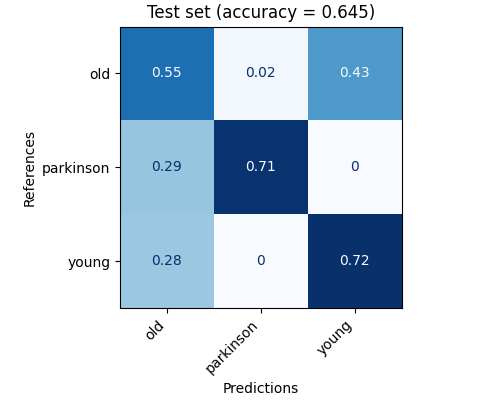

In [15]:
cnn_config = {
    'model': {
        'name': 'cnn',
        'config': {
            'input_size': scaled_intervals.shape[1],
            'output_size': encoded_labels.shape[1],
            'n_layers': 3,
            'n_initial_channels': 8,
            'kernel_size': 3,
        },
    },
    'optimizer': {
        'name': 'adam',
        'config': {
            'lr': 0.0001,
        },
    },
}

cnn_model = train_model(
    name='cnn', 
    config=cnn_config, 
    x=scaled_intervals, 
    y=encoded_labels, 
    i_train=i_train, 
    i_val=i_val,
    batch_size=batch_size,
    n_epochs=n_epochs,
)

cnn_matrices = evaluate_model(
    model=cnn_model, 
    x=scaled_intervals, 
    y=encoded_labels, 
    i_train=i_train, 
    i_val=i_val,
    i_test=i_test,
)

plot_confusion_matrices(cnn_matrices, np.unique(labels))

**Question 6**

What are the main differences of the CNN model with respect the MLP models trained with different optimizers? Does the CNN model overfit?

Can you think of a few reasons to explain why the MLP model trained with the Adam optimizer and the CNN model behave differently in terms of overfitting?

Overall, what is the main limitation of this dataset of stride intervals for training neural network models?

**Answer:**
The CNN model has less parameters and is therefore less prone to overfitting.